TODO:

collate_fn => prediction

random_state=2018

split_test: 7:3

batch_size: 32

manual CLS SEP


# Import Frameworks

In [0]:
# Install frameworks
!pip install transformers

# Import frameworks
import os
import numpy as np
import pandas as pd
import pickle
import torch
import matplotlib.pyplot as plt
import json
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from IPython.display import clear_output
from google.colab import drive

clear_output()

# Setup Environments

In [0]:
# plt setup
%matplotlib inline

# drive setup
drive.mount('/content/drive')
dataset_url = "/content/drive/My Drive/NCKUDMPH2/task1/dataset/"
program_url = "/content/drive/My Drive/NCKUDMPH2/task1/program/"

# setup gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# setup parameters
num_labels = 6
batch_size = 32
epochs = 4
learning_rate = 2e-5

clear_output()

# Setup BERT

In [0]:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME, do_lower_case=True)
model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=num_labels)

clear_output()

# Load Data and split it into Train/Dev/Test

In [0]:
dataset = pd.read_csv(dataset_url+'task1_trainset.csv', dtype=str)

# Drop unuse columns
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

# for i in range(len(dataset['Abstract'])):
#     dataset['Abstract'][i] = remove_stopwords(dataset['Abstract'][i])

# Data Partition
trainset, validset = train_test_split(dataset, test_size=0.1, random_state=2018)

trainset.to_csv(dataset_url+'trainset.csv',index=False)
validset.to_csv(dataset_url+'validset.csv',index=False)

# Test Data
dataset = pd.read_csv(dataset_url+'task1_public_testset.csv')
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

# for i in range(len(dataset['Abstract'])):
#     dataset['Abstract'][i] = remove_stopwords(dataset['Abstract'][i])

dataset.to_csv(dataset_url+'testset.csv',index=False)

# Parse Dataset

In [0]:
def label_to_onehot(labels):
    label_dict = {'BACKGROUND': 0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}
    onehot = [0,0,0,0,0,0]
    for l in labels.split('/'):
        onehot[label_dict[l]] = 1
    return onehot

In [0]:
def label_to_ids_list(sentence):
    new_sent = "[CLS] " + sentence + " [SEP]"
    ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenizer.tokenize(new_sent)]
    return ids


In [0]:
def generate_masks(input_ids):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [0]:
# sent_list += [tokenizer.encode(abstract, add_special_tokens=True)
#               for abstract in abstract_parts]

def generate_dataloader(dataset, labeling, sequntial):
    sent_list, label_list = [], []
    for i in dataset.iterrows():
        abstract_parts = i[1]['Abstract'].split('$$$')
        sent_list += [label_to_ids_list(abstract) for abstract in abstract_parts]
        if labeling:
            label_parts = i[1]['Task 1'].split(" ")
            label_list += [label_to_onehot(label) for label in label_parts]
    input_ids = pad_sequences([txt for txt in sent_list],
                              maxlen=64, dtype="long",
                              truncating="post", padding="post")
    attention_masks = generate_masks(input_ids)
    inputs = torch.tensor(input_ids)
    if labeling:
        labels = torch.tensor(label_list)
    masks = torch.tensor(attention_masks)

    dataset = TensorDataset(
        inputs, masks, labels) if labeling else TensorDataset(inputs, masks)
    train_sampler = SequentialSampler(
        dataset) if sequntial else RandomSampler(dataset)
    return DataLoader(dataset, sampler=train_sampler,
                      batch_size=batch_size, num_workers=0)

In [0]:
trainset = pd.read_csv(dataset_url+'trainset.csv', dtype=str)
validset = pd.read_csv(dataset_url+'validset.csv', dtype=str)
testset = pd.read_csv(dataset_url+'testset.csv', dtype=str)

print("GENERATING TRAIN DATALODAER")
train_dataloader = generate_dataloader(trainset, True, False)
print("GENERATING VALID DATALODAER")
valid_dataloader = generate_dataloader(validset, True, True)
print("GENERATING TEST DATALODAER")
test_dataloader = generate_dataloader(testset, False, True)

GENERATING TRAIN DATALODAER
GENERATING VALID DATALODAER
GENERATING TEST DATALODAER


# Start Training

In [0]:
class F1():
    def __init__(self):
        self.threshold = 0.5
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.uint8)
                                     * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / \
            (self.n_precision + 1e-20)  # prevent divided by zero
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)

In [0]:
def run_epoch(epoch, isTraining):
    model.train(isTraining)

    f1_score = F1()
    loss = 0
    dataloader = train_dataloader if isTraining else valid_dataloader
    desc = "Train" if isTraining else "Valid"
    trange = tqdm(enumerate(dataloader), total=len(
        dataloader), desc=desc)

    for i, batch in trange:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        b_input_ids = b_input_ids.long()
        b_labels = b_labels.float()

        # Extract tensor from tuple
        o_labels = model(b_input_ids, b_input_mask)[0]
        batch_loss = criteria(o_labels, b_labels)

        if isTraining:
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        loss += batch_loss.item()
        f1_score.update(o_labels, b_labels)
        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
        history['train' if isTraining else 'valid'].append(
            {'f1': f1_score.get_score(), 'loss': loss / len(trange)})

In [0]:
def save(epoch):
    if not os.path.exists(program_url+'model'):
        os.makedirs(program_url+'model')
    torch.save(model.state_dict(), program_url+'model/model.pkl.'+str(epoch))
    with open(program_url+'model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer
                if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer
                if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
]

# BCELoss can't handle negative values
criteria = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)
model.to(device)
history = {'train': [], 'valid': []}

train_loss_set = []

for epoch in range(epochs):
    run_epoch(epoch, True)
    run_epoch(epoch, False)
    save(epoch)

Valid: 100%|██████████| 149/149 [00:36<00:00,  4.38it/s, f1=0.00000, loss=0.447]


# Ploting the Results

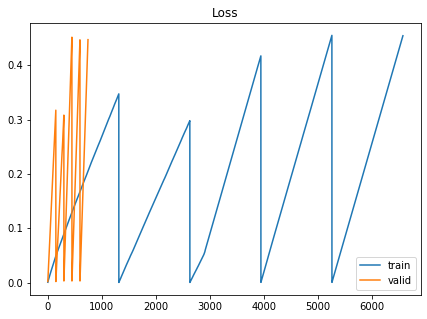

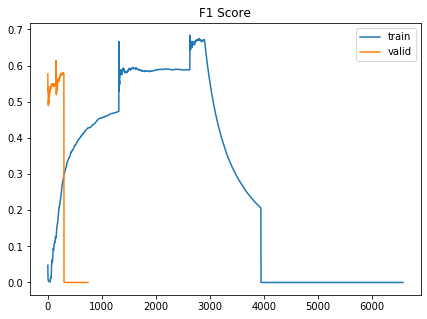

Best F1 score  [0.6140350877192982, 150]


In [0]:
with open(program_url+'model/history.json', 'r') as f:
    history = json.loads(f.read())

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7, 5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx]
                             for idx, l in enumerate(history['valid'])]))

# Prediction

In [0]:
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['BACKGROUND'] = list(prediction[:,0]) + [0]*redundant
        submit['OBJECTIVES'] = list(prediction[:,1]) + [0]*redundant
        submit['METHODS'] = list(prediction[:,2]) + [0]*redundant
        submit['RESULTS'] = list(prediction[:,3]) + [0]*redundant
        submit['CONCLUSIONS'] = list(prediction[:,4]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,5]) + [0]*redundant
    else:
        submit['BACKGROUND'] = [0]*redundant + list(prediction[:,0])
        submit['OBJECTIVES'] = [0]*redundant + list(prediction[:,1])
        submit['METHODS'] = [0]*redundant + list(prediction[:,2])
        submit['RESULTS'] = [0]*redundant + list(prediction[:,3])
        submit['CONCLUSIONS'] = [0]*redundant + list(prediction[:,4])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,5])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [0]:
model.train(False)
trange = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc='Test')
prediction = []  # prediction will be a (131166, 6) list

for i, batch in trange:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    b_input_ids = b_input_ids.long()
    with torch.no_grad():
        o_labels = model(b_input_ids, b_input_mask)[0]
    o_labels = o_labels > 0.5
    batch_result = np.where(o_labels.cpu().numpy(), 1, 0)  # convert True/False into 1/0
    prediction.extend(batch_result)
prediction = np.array(prediction)

Test: 100%|██████████| 4099/4099 [16:36<00:00,  4.15it/s]


# Submit Prediction Results

In [0]:
SubmitGenerator(prediction,
                dataset_url+'task1_sample_submission.csv', 
                True, 
                dataset_url+'task1_submission.csv')